# Spam Email Identifier

The purpose of this notebook is to create and train a model that can predict, with high accuracy, whether a given email is a spam or not (ham). This is a binary classification problem that involves Natural Language Processing (NLP).

I will be using the <a href='http://www2.aueb.gr/users/ion/data/enron-spam/'>enron spam email dateset</a>.

Contents:

1. [Installing and Importing Dependencies](#libraries)
2. [Loading the Dataset](#load_dataset)
3. [Exploratory Data Analysis](#eda)
4. [Feature Engineering](#feature_engineering)
4. [Model Training](#train)
5. [Testing Model Predictions](#inference)
5. [Best Model](#best_model)
6. [Model Inference Deployment](#deployment)

## <a class="anchor" id="libraries">Installing and Importing Dependencies</a>

This notebook makes use of the following dependencies:
* <a href='https://www.nltk.org/'>NLTK</a> - Natural Language Toolkit for Python
* <a href='https://scikit-learn.org/'>Scikit-learn</a> - Preprocessing and Machine Learning
* <a href='https://pandas.pydata.org/'>Pandas</a> - Data analysis and visualization
* <a href='https://numpy.org/'>Numpy</a> - Scientific computing
* <a href='https://seaborn.pydata.org/'>Seaborn</a> - Statistical data visualization

**This notebook is meant to work locally, it needs to be altered to be used in an AWS SageMaker environment.**

In [163]:
# Install and download required modules for NLTK
# ONLY RUN THIS ONCE
# !conda install nltk #This installs nltk in a conda environment
# !pip install nltk #This installs nltk using pip
# nltk.download('stopwords') #Download the necessary datasets

In [2]:
# Load the dataset
import os
from pathlib import Path
import urllib.request
import tarfile
from sklearn.datasets import load_files
#Exploratory Data Analysis
import pandas as pd
import numpy as np
# Data Visualization
import seaborn as sns
from matplotlib import pyplot as plt
sns.color_palette("Spectral", as_cmap=True)
sns.set()
%matplotlib inline
#Feature Engineering - Text pre-processing
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
#Feature Engineering - Vectorization with Bag of words + TF-IDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# Model Training
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from sklearn.linear_model import SGDClassifier # SVM Linear classifier with SGD
from sklearn.neighbors import KNeighborsClassifier # K-nearest neighbors
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.pipeline import Pipeline

## <a class="anchor" id="load_dataset">Loading the Dataset</a>

Download the dataset from the original source

In [9]:
#Create folder structure where the dataset will be stored
dataset_folder_path = "../enron_datasets/spam_dataset"
dataset_folder = Path(dataset_folder_path)
dataset_folder.mkdir(parents=True, exist_ok=True)
# Download the dataset from the source location
for i in range(1, 7):
    urllib.request.urlretrieve("http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron"+str(i)+".tar.gz", "../enron_datasets/spam_dataset/enron"+str(i)+".tar.gz")
    file = tarfile.open(str(Path(dataset_folder_path+'/enron'+str(i)+'.tar.gz').absolute()))
    file.extractall(dataset_folder_path)

Load emails from the dataset into a pandas dataframe

In [165]:
X, y = [], []
dirpath = '../enron_datasets/spam_dataset'
for subdir in os.listdir(dirpath):
    # if os.path.isdir and subdir != '.DS_Store':
    if os.path.isdir and subdir  == 'enron1':
        print(f"Loading files from path {os.path.join(dirpath, subdir)}")
        email_dataset = load_files(os.path.join(dirpath, subdir))
        X = np.append(X, email_dataset.data)
        y = np.append(y, email_dataset.target)

# Create pandas dataframe for further analysis and manipulation
print("Creating pandas dataframe for further analysis and manipulation...")
emails = pd.DataFrame(columns=['label', 'label_name', 'text'])
emails['label'] = [y for y in y]
emails['label_name'] = emails.apply (lambda row: 'ham' if row.label == 0 else 'spam', axis=1)
emails['text'] = [x for x in X]

print("done!")

Loading files from path ../enron_datasets/spam_dataset/enron1
Creating pandas dataframe for further analysis and manipulation...
done!


## <a class="anchor" id="eda">Exploratory Data Analysis</a>

### Reviewing the dataset

Checking contents and statistics of the dataset using head(), describe() and info()

In [166]:
# Checking the data to work with, it contains a label represented by an integer index, a label name, and text contents of each email.
emails.head()

,label,label_name,text
0,0.0,ham,b'Subject: nesa / hea \' s 24 th annual meetin...
1,0.0,ham,b'Subject: meter 1431 - nov 1999\r\ndaren -\r\...
2,1.0,spam,"b""Subject: investor here .\r\nfrom : mr . rich..."
3,1.0,spam,"b""Subject: hi paliourg all available meds . av..."
4,0.0,ham,b'Subject: january nominations at shell deer p...


In [167]:
# Checking for total number of rows (email records)
emails.describe()

,label
count,5172.000000
mean,0.290023
std,0.453817
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [168]:
# Checking for data types
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   label       5172 non-null   float64
 1   label_name  5172 non-null   object 
 2   text        5172 non-null   object 
dtypes: float64(1), object(2)
memory usage: 121.3+ KB


Checking the number of emails that are spam vs. ham

<AxesSubplot:xlabel='label_name', ylabel='count'>

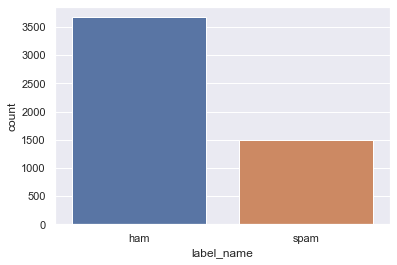

In [169]:
sns.countplot(x='label_name',data=emails)

In [170]:
# Contents by label (ham or spam)
emails.groupby('label_name').describe()

label                                   
             count mean  std  min  25%  50%  75%  max
label_name                                           
ham         3672.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
spam        1500.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

### Length Analysis
It's useful to review the length of the emails,a s it could be an good indicator of whether an email can be classified as spam or not.

In [171]:
# Checking if length could be an additional feature of importance
emails['text_length'] = emails['text'].apply(len)
emails.head()

,label,label_name,text,text_length
0,0.0,ham,b'Subject: nesa / hea \' s 24 th annual meetin...,2246
1,0.0,ham,b'Subject: meter 1431 - nov 1999\r\ndaren -\r\...,881
2,1.0,spam,"b""Subject: investor here .\r\nfrom : mr . rich...",2445
3,1.0,spam,"b""Subject: hi paliourg all available meds . av...",2196
4,0.0,ham,b'Subject: january nominations at shell deer p...,1496


In [172]:
emails['text_length'].describe()

count     5172.000000
mean      1048.877224
std       1528.670906
min         11.000000
25%        244.000000
50%        540.000000
75%       1237.000000
max      32258.000000
Name: text_length, dtype: float64

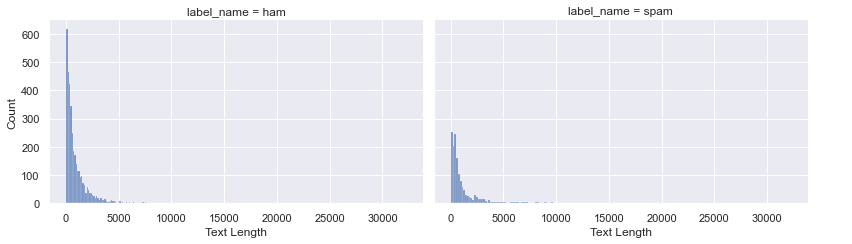

In [173]:
g = sns.FacetGrid(emails, col="label_name", margin_titles=True, height=3.5, aspect=1.65) 
g.map(sns.histplot,"text_length")
g.set_axis_labels("Text Length", "Count")
g.add_legend()

<AxesSubplot:title={'center':'Histogram Log Scale'}, xlabel='text_length', ylabel='Count'>

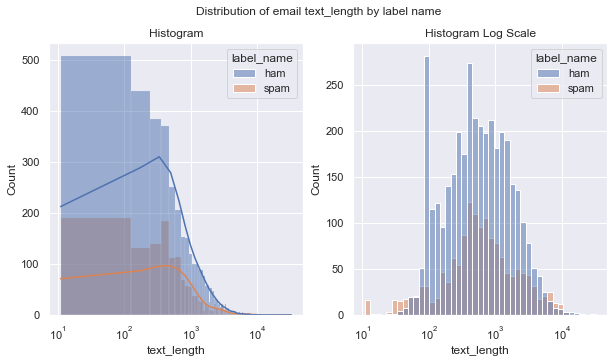

In [174]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig.suptitle('Distribution of email text_length by label name')
axes[0].set_title('Histogram')
axes[1].set_title('Histogram Log Scale')
sns.histplot(ax=axes[0],x=emails['text_length'], hue=emails['label_name'],kde=True, log_scale=False)
sns.histplot(ax=axes[1],x=emails['text_length'], hue=emails['label_name'],kde=False, log_scale=True)

## <a class="anchor" id="feature_engineering">Feature Engineering</a>

### Review Data Types

Before we can manipulate the data, we have to make sure their data types are updated

In [175]:
# Convert object data types to string
emails = emails.astype({'label_name': 'string', 'text': 'string'})
emails.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   label        5172 non-null   float64
 1   label_name   5172 non-null   string 
 2   text         5172 non-null   string 
 3   text_length  5172 non-null   int64  
dtypes: float64(1), int64(1), string(2)
memory usage: 161.8 KB


### Text Pre-processing

Emails texts need to be pre-processed before we can feed them to a machine learning algorithm for training. Here are the things we need to take care of:
1. Remove the 'b' character in the beggining of each text
2. Remove Special symbols such as \r, \n, \t
3. Remove Punctuation marks
4. Remove Stopwords
5. Convert all text to lowercase
6. Stemming or Lemmatization (Optional)

In [176]:
# Sample raw email text
emails['text'][0]

'b\'Subject: nesa / hea \\\' s 24 th annual meeting\\r\\nsaddle up for nesa / hea \\\' s 24 th annual meeting\\r\\n" deep in the heart of texas "\\r\\nseptember 9 - 11 , 2001\\r\\nhyatt regency hill country resort\\r\\nsan antonio , texas\\r\\nthe annual meeting planning committee has put together an outstanding\\r\\nprogram for your review . it is attached below in an adobe acrobat pdf file\\r\\n- if you have problems with the attachment please call nesa / hea\\r\\nheadquarters at ( 713 ) 856 - 6525 and we \\\' ll mail or fax a copy out immediately .\\r\\ngeneral session topics include :\\r\\n* will tomorrow \\\' s restructured electric infrastructure support\\r\\ntomorrow \\\' s economy ?\\r\\n* power deregulation panel : developer / ipp , utility / transmission , power\\r\\nmarketer , government , retail\\r\\n* power demand\\r\\n* the state of the energy industry\\r\\n* new political administration - impact on energy policy and\\r\\nenvironment\\r\\nnetworking opportunities :\\r\\n*

The following function takes care of all the pre-processing steps:

In [177]:
def email_text_preprocessing(document_text,text_normalization='none'):
    '''
    :param str document: document to be pre-processed in text format.
    :param str text_normalization: It defines the type of normalization to be applied, possible values are: 'none', 'stemming', 'lemmatization'
    1. Remove b' characters that appear at the beggining of each email
    2. Remove special characters
    3. Remove punctuation marks
    4. Remove stopwords
    5. Stem, Lemmatize text, or do nothing else.
    '''
    alt_text = re.sub(r'^b\'', '', document_text)
    alt_text = re.sub(r'\\r\\n', ' ', alt_text)
    alt_text = re.sub(r'\s+',' ',alt_text)
    no_punct = [char for char in alt_text if char not in string.punctuation]
    no_punct = ''.join(no_punct)
    no_stopwords = [word for word in no_punct.split() if word.lower() not in stopwords.words('english')]
    res_text = None
    if text_normalization == 'stemming':
        stemmer = PorterStemmer()
        stemmed = [stemmer.stem(word) for word in no_stopwords]
        stemmed = ' '.join(stemmed)
        res_text = stemmed
    elif text_normalization == 'lemmatization':
        lemmatizer = WordNetLemmatizer()
        lemmatized = [lemmatizer.lemmatize(word) for word in no_stopwords]
        lemmatized = ' '.join(lemmatized)
        res_text = lemmatized
    else:
        res_text = ' '.join(no_stopwords)

    return res_text

Test the function against a single email

In [178]:
test_text = str(emails['text'][10])
print("Before pre-processing:")
print(test_text)
print('***************')
print("After pre-processing:")
test_text = email_text_preprocessing(test_text)
print(test_text)
print('***************')
print("After pre-processing with Stemming:")
test_text = email_text_preprocessing(test_text, text_normalization='stemming')
print(test_text)
print('***************')
print("After pre-processing with Lemmatization:")
test_text = email_text_preprocessing(test_text, text_normalization='lemmatization')
print(test_text)

Before pre-processing:
b'Subject: rates\r\ndaren -\r\nrates for september :\r\nt - ville interconnects to equistar channelview $ . 15\r\nagua dulce interconnects to equistar channelview $ . 13\r\nlet me know if you get something done or need quotes on something else ! term rate on # 6461 to follow .'
***************
After pre-processing:
Subject rates daren rates september ville interconnects equistar channelview 15 agua dulce interconnects equistar channelview 13 let know get something done need quotes something else term rate 6461 follow
***************
After pre-processing with Stemming:
subject rate daren rate septemb vill interconnect equistar channelview 15 agua dulc interconnect equistar channelview 13 let know get someth done need quot someth els term rate 6461 follow
***************
After pre-processing with Lemmatization:
subject rate daren rate septemb vill interconnect equistar channelview 15 agua dulc interconnect equistar channelview 13 let know get someth done need quot 

Later on, I'll apply the processing function to all the data as part of a processing pipeline.

In [179]:
#Create new column in data frame with pre-proccesed text (simple)
emails['preprocessed_text_simple'] = ''
emails.astype({'preprocessed_text_simple': 'string'}).dtypes
emails['preprocessed_text_simple'] = emails['text']
emails['preprocessed_text_simple'] = emails['preprocessed_text_simple'].apply(lambda x: email_text_preprocessing(str(x), text_normalization='none'))

#Create new column in data frame with pre-proccesed text (stemmed)
emails['preprocessed_text_stemmed'] = ''
emails.astype({'preprocessed_text_stemmed': 'string'}).dtypes
emails['preprocessed_text_stemmed'] = emails['text']
emails['preprocessed_text_stemmed'] = emails['preprocessed_text_stemmed'].apply(lambda x: email_text_preprocessing(str(x), text_normalization='stemming'))

#Create new column in data frame with pre-proccesed text (lemmatized)
emails['preprocessed_text_lemmatized'] = ''
emails.astype({'preprocessed_text_lemmatized': 'string'}).dtypes
emails['preprocessed_text_lemmatized'] = emails['text']
emails['preprocessed_text_lemmatized'] = emails['preprocessed_text_lemmatized'].apply(lambda x: email_text_preprocessing(str(x), text_normalization='lemmatization'))

emails.head()

,label,label_name,text,text_length,preprocessed_text_simple,preprocessed_text_stemmed,preprocessed_text_lemmatized
0,0.0,ham,b'Subject: nesa / hea \' s 24 th annual meetin...,2246,Subject nesa hea 24 th annual meeting saddle n...,subject nesa hea 24 th annual meet saddl nesa ...,Subject nesa hea 24 th annual meeting saddle n...
1,0.0,ham,b'Subject: meter 1431 - nov 1999\r\ndaren -\r\...,881,Subject meter 1431 nov 1999 daren could please...,subject meter 1431 nov 1999 daren could pleas ...,Subject meter 1431 nov 1999 daren could please...
2,1.0,spam,"b""Subject: investor here .\r\nfrom : mr . rich...",2445,bSubject investor mr richard mayer dear friend...,bsubject investor mr richard mayer dear friend...,bSubject investor mr richard mayer dear friend...
3,1.0,spam,"b""Subject: hi paliourg all available meds . av...",2196,bSubject hi paliourg available meds available ...,bsubject hi paliourg avail med avail binaur cv...,bSubject hi paliourg available med available b...
4,0.0,ham,b'Subject: january nominations at shell deer p...,1496,Subject january nominations shell deer park fy...,subject januari nomin shell deer park fyi requ...,Subject january nomination shell deer park fyi...


### Vectorization

Most machine learning algorithms, and most deep learning frameworks are not capable of processing strings of text. They require numerical numbers as inputs to perform their tasks (in this case, spam classification). In Natural Language Processing, word embeddings or word vectorization is a methodology used to convert text into numerical vectors.

In order to get the email text data ready to be processed, the following techniques will be applied:
* **Bag of words** - To convert each email text from the whole corpus into a numeric vector. Numbers are based on counting word occurrence in each email. It doesn't preserve the word order
* **TF-IDF (Term Frequency - Inverse Document Frequency)** - To consider the importance of each word within each email and the whole corpus. It generates weights that signify how important a word is for a given email.

In [180]:
# Bag of words for a sample sentence
sample_bow_df =  pd.DataFrame(columns=['text'])
sample_bow_df = sample_bow_df.astype({'text': 'string'})
sample_bow_df = sample_bow_df.append({ 'text' : email_text_preprocessing(test_text, text_normalization='none')},ignore_index = True)
sample_bow_df.head(10)
sample_bow = CountVectorizer().fit_transform(sample_bow_df['text'])
print(f"BOW Shape: {sample_bow.shape}")
print('Amount of Non-Zero occurences: ', sample_bow.nnz)

BOW Shape: (1, 23)
Amount of Non-Zero occurences:  23


In [181]:
# TF-IDF from Bag or Words
vectors = TfidfTransformer().fit_transform(sample_bow)
vectors_list = vectors.todense().tolist()
print(f"TF-IDF Vector shape: {vectors.shape}")


TF-IDF Vector shape: (1, 23)


## <a class="anchor" id="train">Model Training</a>

### Creating a Data Pipeline

Now that we have a way to transform the raw email text data into numeric vectors, that can be passed to machine learning algorithms. It is convenient to put all the processing, alongside the model training, into a data pipeline. A pipeline will concatenate the outputs of all the data manipulations (Transformers), and then also pass it as an input to a given Estimator (algorithm).

For local training, I will be using the following estimators from scikit-learn:
* Naive Bayes
* SVM Linear classifier with SGD
* K-nearest neighbors
* Random Forest

In [183]:
# Create and visualize a simple data pipeline
set_config(display='diagram')
simple_pipeline = Pipeline([
    ('bow', CountVectorizer()),  # Text pre-processing and Bag of words vectorization
    ('tfidf', TfidfTransformer()),  # Integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # Train on TF-IDF vectors using a Naive Bayes classifier
])
simple_pipeline

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In order to be able to train different algorithms, it would be good if we can have a function that dinamycally changes the classifier used for training:

In [196]:
def build_data_pipeline(classifier='nb', tfidf=True):
    classifier_obj = None
    if classifier == 'nb':
        classifier_obj = MultinomialNB()
    elif classifier == 'svm':
        classifier_obj = SGDClassifier()
    elif classifier == 'knn':
        classifier_obj = KNeighborsClassifier()
    elif classifier == 'rf':
        classifier_obj = RandomForestClassifier()
    else:
        raise ValueError('Classifier should be one of the following values: nb (Naive Bayes), svm (Support Vector Machine), knn (K-Nearest Neighbors), rf (Random Forest)')
    
    if tfidf:
        pipeline = Pipeline([
            ('bow', CountVectorizer()),  # Text pre-processing and Bag of words vectorization
            ('tfidf', TfidfTransformer()),  # Integer counts to weighted TF-IDF scores
            ('classifier', classifier_obj),  # Train on selected classifier
        ])
    else:
        pipeline = Pipeline([
            ('bow', CountVectorizer()),  # Text pre-processing and Bag of words vectorization
            ('classifier', classifier_obj),  # Train on selected classifier
        ])

    return pipeline


In [197]:
# Sample pipeline with a classifier parameter
rf_pipeline = build_data_pipeline(classifier='rf')
rf_pipeline

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

### Train, Validation and Test Splits

The data will be split into training (60%), validation (20%) and test (20%) subsets. I will generate different train, validation, test datasets. Changing the type of text_normalization to be used, and then one that contains all the features from the emails dataframe.

In [186]:
# All features
# Split into train and test - all features
X = emails.drop(columns=['label', 'label_name', 'text'])
X_train, X_test, y_train, y_test = \
    train_test_split(X, emails['label_name'], test_size=0.2)
# Split train into train and validation - all features
X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25) # 0.25 x 0.8 = 0.2

# preprocessed_text_simple
X_train_simple, X_test_simple, y_train_simple, y_test_simple = \
    train_test_split(emails['preprocessed_text_simple'], emails['label_name'], test_size=0.2)
X_train_simple, X_val_simple, y_train_simple, y_val_simple = \
    train_test_split(X_train_simple, y_train_simple, test_size=0.25) # 0.25 x 0.8 = 0.2

# preprocessed_text_stemmed
X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = \
    train_test_split(emails['preprocessed_text_stemmed'], emails['label_name'], test_size=0.2)
X_train_stemmed, X_val_stemmed, y_train_stemmed, y_val_stemmed = \
    train_test_split(X_train_stemmed, y_train_stemmed, test_size=0.25) # 0.25 x 0.8 = 0.2

# preprocessed_text_lemmatized
X_train_lemmatized, X_test_lemmatized, y_train_lemmatized, y_test_lemmatized = \
    train_test_split(emails['preprocessed_text_lemmatized'], emails['label_name'], test_size=0.2)
X_train_lemmatized, X_val_lemmatized, y_train_lemmatized, y_val_lemmatized = \
    train_test_split(X_train_lemmatized, y_train_lemmatized, test_size=0.25) # 0.25 x 0.8 = 0.2

print(f"All Features:")
print(f"Train Data Length:      {len(X_train)}")
print(f"Validation Data Length: {len(X_val)}")
print(f"Test Data Length:       {len(X_test)}")
print(f"Total:                  {len(X_train)+len(X_val)+len(X_test)}")
print(f"-------------------------------")
print(f"Simple normalization:")
print(f"Train Data Length:      {len(X_train_simple)}")
print(f"Validation Data Length: {len(X_val_simple)}")
print(f"Test Data Length:       {len(X_test_simple)}")
print(f"Total:                  {len(X_train_simple)+len(X_val_simple)+len(X_test_simple)}")
print(f"-------------------------------")
print(f"Stemmed normalization:")
print(f"Train Data Length:      {len(X_train_stemmed)}")
print(f"Validation Data Length: {len(X_val_stemmed)}")
print(f"Test Data Length:       {len(X_test_stemmed)}")
print(f"Total:                  {len(X_train_stemmed)+len(X_val_stemmed)+len(X_test_stemmed)}")
print(f"-------------------------------")
print(f"Lemmatized normalization:")
print(f"Train Data Length:      {len(X_train_lemmatized)}")
print(f"Validation Data Length: {len(X_val_lemmatized)}")
print(f"Test Data Length:       {len(X_test_lemmatized)}")
print(f"Total:                  {len(X_train_lemmatized)+len(X_val_lemmatized)+len(X_test_lemmatized)}")
print(f"-------------------------------")



All Features:
Train Data Length:      3102
Validation Data Length: 1035
Test Data Length:       1035
Total:                  5172
-------------------------------
Simple normalization:
Train Data Length:      3102
Validation Data Length: 1035
Test Data Length:       1035
Total:                  5172
-------------------------------
Stemmed normalization:
Train Data Length:      3102
Validation Data Length: 1035
Test Data Length:       1035
Total:                  5172
-------------------------------
Lemmatized normalization:
Train Data Length:      3102
Validation Data Length: 1035
Test Data Length:       1035
Total:                  5172
-------------------------------


### Model Training and Validation

### Naive Bayes

The first classifier to use for testing against the validation datasets will be Naive Bayes. Several combinations will be tested, including variations of text normalization (Simple, Stemming, Lemmatization), as well as simple bag of words or TF-IDF.

The important metrics to look for are:

* **Accuracy** - Ratio of correctly predicted observations against total # of observations. How many predictions (ham and spam) did the model get right?
* **Precision** - Ratio of correctly predicted positive observations against total predicted positive observations. Of all emails classified as ham/spam, how many were actually ham/spam?
* **Recall** - Also known as sensitivity. Ratio of correctly predicted positive observations against all observations that were actually positive. Of all the emails that are actually ham/spam, how many were corretly labeled as ham/spam?

For this case, the cost of incorrectly classifying a valid ("ham") email as spam is higher than incorrectly classifying a spam email as "ham".

Therefore, in addition to **accuracy**, we need to play close attention to the following:
 1. **recall metric for ham predictions**, which will tell us the percentage of emails that are correctly classsified as ham.
 2. **precision metric for spam predictions**, which will tell us the percentage of emails classified as spam, that are actually spam.

#### Simple normalization

In [191]:
# Create pipeline
nb_simple_pipeline = build_data_pipeline(classifier='nb')
# Train
nb_simple_pipeline.fit(X_train_simple,y_train_simple)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

Now we perform the first predicitons, using the validation dataset:

In [192]:
nb_val_simple_predictions = nb_simple_pipeline.predict(X_val_simple)
print(f"Confusion Matrix:")
print(confusion_matrix(y_val_simple,nb_val_simple_predictions))
print(f"Classification Report:")
print(classification_report(nb_val_simple_predictions,y_val_simple))

Confusion Matrix:
[[750   0]
 [ 88 197]]
Classification Report:
              precision    recall  f1-score   support

         ham       1.00      0.89      0.94       838
        spam       0.69      1.00      0.82       197

    accuracy                           0.91      1035
   macro avg       0.85      0.95      0.88      1035
weighted avg       0.94      0.91      0.92      1035



#### Simple Normalization (without TF-IDF)

In [198]:
# Create pipeline
nb_simple_pipeline = build_data_pipeline(classifier='nb', tfidf=False)
# Train
nb_simple_pipeline.fit(X_train_simple,y_train_simple)
nb_val_simple_predictions = nb_simple_pipeline.predict(X_val_simple)
print(f"Confusion Matrix:")
print(confusion_matrix(y_val_simple,nb_val_simple_predictions))
print(f"Classification Report:")
print(classification_report(nb_val_simple_predictions,y_val_simple))

Confusion Matrix:
[[739  11]
 [ 16 269]]
Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       755
        spam       0.94      0.96      0.95       280

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



#### Stemmed normalization

In [193]:
# Create pipeline
nb_stemmed_pipeline = build_data_pipeline(classifier='nb')
# Train
nb_stemmed_pipeline.fit(X_train_stemmed,y_train_stemmed)
# Predict against validation dataset
nb_val_stemmed_predictions = nb_stemmed_pipeline.predict(X_val_stemmed)
print(f"Confusion Matrix:")
print(confusion_matrix(y_val_stemmed,nb_val_stemmed_predictions))
print(f"Classification Report:")
print(classification_report(nb_val_stemmed_predictions,y_val_stemmed))

Confusion Matrix:
[[737   1]
 [101 196]]
Classification Report:
              precision    recall  f1-score   support

         ham       1.00      0.88      0.94       838
        spam       0.66      0.99      0.79       197

    accuracy                           0.90      1035
   macro avg       0.83      0.94      0.86      1035
weighted avg       0.93      0.90      0.91      1035



#### Stemmed normalization (without TF-IDF)

In [199]:
# Create pipeline
nb_stemmed_pipeline = build_data_pipeline(classifier='nb', tfidf=False)
# Train
nb_stemmed_pipeline.fit(X_train_stemmed,y_train_stemmed)
# Predict against validation dataset
nb_val_stemmed_predictions = nb_stemmed_pipeline.predict(X_val_stemmed)
print(f"Confusion Matrix:")
print(confusion_matrix(y_val_stemmed,nb_val_stemmed_predictions))
print(f"Classification Report:")
print(classification_report(nb_val_stemmed_predictions,y_val_stemmed))

Confusion Matrix:
[[721  17]
 [ 15 282]]
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       736
        spam       0.95      0.94      0.95       299

    accuracy                           0.97      1035
   macro avg       0.96      0.96      0.96      1035
weighted avg       0.97      0.97      0.97      1035



#### Lemmatized normalization

In [194]:
# Create pipeline
nb_lemmatized_pipeline = build_data_pipeline(classifier='nb')
# Train
nb_lemmatized_pipeline.fit(X_train_lemmatized,y_train_lemmatized)
# Predict against validation dataset
nb_val_lemmatized_predictions = nb_lemmatized_pipeline.predict(X_val_lemmatized)
print(f"Confusion Matrix:")
print(confusion_matrix(y_val_lemmatized,nb_val_lemmatized_predictions))
print(f"Classification Report:")
print(classification_report(nb_val_lemmatized_predictions,y_val_lemmatized))

Confusion Matrix:
[[735   1]
 [ 83 216]]
Classification Report:
              precision    recall  f1-score   support

         ham       1.00      0.90      0.95       818
        spam       0.72      1.00      0.84       217

    accuracy                           0.92      1035
   macro avg       0.86      0.95      0.89      1035
weighted avg       0.94      0.92      0.92      1035



#### Lemmatized normalization (without TF-IDF)

In [203]:
# Create pipeline
nb_lemmatized_pipeline = build_data_pipeline(classifier='nb', tfidf=False)
# Train
nb_lemmatized_pipeline.fit(X_train_lemmatized,y_train_lemmatized)
# Predict against validation dataset
nb_val_lemmatized_predictions = nb_lemmatized_pipeline.predict(X_val_lemmatized)
print(f"Confusion Matrix:")
print(confusion_matrix(y_val_lemmatized,nb_val_lemmatized_predictions))
print(f"Classification Report:")
print(classification_report(nb_val_lemmatized_predictions,y_val_lemmatized))

Confusion Matrix:
[[722  14]
 [ 12 287]]
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       734
        spam       0.96      0.95      0.96       301

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



After testing several combinations, it turns out that the best result is given by the model that used lemmatized normalization and doesn't use TF-IDF.

* **Accuracy: 97%**
* **Ham Recall: 98%**
* **Spam Precision: 96%**

### Support Vector Machine with Stochastic Gradient Descent (SVM with SGD)

The second classifier to use for testing against the validation datasets will be Suport Vector Machine with SGD. Since we already noticed that Lemmatized normalization without TF-IDF seems to yield best results, that will be the only variation to be tested.

**Important metrics to look for**

In this case, the cost of incorrectly classifying a valid ("ham") email as spam is higher than incorrectly classifying a spam email as "ham".

Therefore, in addition to **accuracy**, we need to play close attention to the following:
 1. **recall metric for ham predictions**, which will tell us the percentage of emails that are correctly classsified as ham.
 2. **precision metric for spam predictions**, which will tell us the percentage of emails classified as spam, that are actually spam.

#### Lemmatized normalization (without TF-IDF)

In [206]:
# Create pipeline
svm_lemmatized_pipeline = build_data_pipeline(classifier='svm', tfidf=False)
# Train
svm_lemmatized_pipeline.fit(X_train_lemmatized,y_train_lemmatized)
# Predict against validation dataset
svm_val_lemmatized_predictions = svm_lemmatized_pipeline.predict(X_val_lemmatized)
print(f"Confusion Matrix:")
print(confusion_matrix(y_val_lemmatized,svm_val_lemmatized_predictions))
print(f"Classification Report:")
print(classification_report(svm_val_lemmatized_predictions,y_val_lemmatized))

Confusion Matrix:
[[725  11]
 [ 14 285]]
Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.98      0.98       739
        spam       0.95      0.96      0.96       296

    accuracy                           0.98      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



* **Accuracy: 98%**
* **Ham Recall: 98%**
* **Spam Precision: 95%**

### K-Nearest Neighbors

The third classifier to use for testing against the validation datasets will be K-Nearest Neighbors with default parameters. Since we already noticed that Lemmatized normalization without TF-IDF seems to yield best results, that will be the only variation to be tested.

**Important metrics to look for**

In this case, the cost of incorrectly classifying a valid ("ham") email as spam is higher than incorrectly classifying a spam email as "ham".

Therefore, in addition to **accuracy**, we need to play close attention to the following:
 1. **recall metric for ham predictions**, which will tell us the percentage of emails that are correctly classsified as ham.
 2. **precision metric for spam predictions**, which will tell us the percentage of emails classified as spam, that are actually spam.

#### Lemmatized normalization (without TF-IDF)

In [207]:
# Create pipeline
knn_lemmatized_pipeline = build_data_pipeline(classifier='knn', tfidf=False)
# Train
knn_lemmatized_pipeline.fit(X_train_lemmatized,y_train_lemmatized)
# Predict against validation dataset
knn_val_lemmatized_predictions = knn_lemmatized_pipeline.predict(X_val_lemmatized)
print(f"Confusion Matrix:")
print(confusion_matrix(y_val_lemmatized,knn_val_lemmatized_predictions))
print(f"Classification Report:")
print(classification_report(knn_val_lemmatized_predictions,y_val_lemmatized))

Confusion Matrix:
[[536 200]
 [ 14 285]]
Classification Report:
              precision    recall  f1-score   support

         ham       0.73      0.97      0.83       550
        spam       0.95      0.59      0.73       485

    accuracy                           0.79      1035
   macro avg       0.84      0.78      0.78      1035
weighted avg       0.83      0.79      0.78      1035



* **Accuracy: 79%**
* **Ham Recall: 97%**
* **Spam Precision: 95%**

### Random Forest

The fourth classifier to use for testing against the validation datasets will be Random Forest decision trees. Since we already noticed that Lemmatized normalization without TF-IDF seems to yield best results, that will be the only variation to be tested.

**Important metrics to look for**

In this case, the cost of incorrectly classifying a valid ("ham") email as spam is higher than incorrectly classifying a spam email as "ham".

Therefore, in addition to **accuracy**, we need to play close attention to the following:
 1. **recall metric for ham predictions**, which will tell us the percentage of emails that are correctly classsified as ham.
 2. **precision metric for spam predictions**, which will tell us the percentage of emails classified as spam, that are actually spam.

#### Lemmatized normalization (without TF-IDF)

In [208]:
# Create pipeline
rf_lemmatized_pipeline = build_data_pipeline(classifier='rf', tfidf=False)
# Train
rf_lemmatized_pipeline.fit(X_train_lemmatized,y_train_lemmatized)
# Predict against validation dataset
rf_val_lemmatized_predictions = rf_lemmatized_pipeline.predict(X_val_lemmatized)
print(f"Confusion Matrix:")
print(confusion_matrix(y_val_lemmatized,rf_val_lemmatized_predictions))
print(f"Classification Report:")
print(classification_report(rf_val_lemmatized_predictions,y_val_lemmatized))

Confusion Matrix:
[[718  18]
 [  7 292]]
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       725
        spam       0.98      0.94      0.96       310

    accuracy                           0.98      1035
   macro avg       0.98      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



* **Accuracy: 98%**
* **Ham Recall: 99%**
* **Spam Precision: 98%**

## <a class="anchor" id="inference">Testing Model Predictions</a>

To test against the test dataset, I'll only pick the top 3 best performing models:

1. Random Forest
2. Naive Bayes
3. SVM

### Random Forest

In [209]:
# Predict against test dataset
rf_test_lemmatized_predictions = rf_lemmatized_pipeline.predict(X_test_lemmatized)
print(f"Confusion Matrix:")
print(confusion_matrix(y_test_lemmatized,rf_test_lemmatized_predictions))
print(f"Classification Report:")
print(classification_report(rf_test_lemmatized_predictions,y_test_lemmatized))

Confusion Matrix:
[[732  16]
 [ 11 276]]
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       743
        spam       0.96      0.95      0.95       292

    accuracy                           0.97      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.97      0.97      0.97      1035



### Naive Bayes

In [210]:
# Predict against test dataset
nb_test_lemmatized_predictions = nb_lemmatized_pipeline.predict(X_test_lemmatized)
print(f"Confusion Matrix:")
print(confusion_matrix(y_test_lemmatized,nb_test_lemmatized_predictions))
print(f"Classification Report:")
print(classification_report(nb_test_lemmatized_predictions,y_test_lemmatized))

Confusion Matrix:
[[737  11]
 [ 21 266]]
Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       758
        spam       0.93      0.96      0.94       277

    accuracy                           0.97      1035
   macro avg       0.96      0.97      0.96      1035
weighted avg       0.97      0.97      0.97      1035



### SVM

In [211]:
svm_test_lemmatized_predictions = svm_lemmatized_pipeline.predict(X_test_lemmatized)
print(f"Confusion Matrix:")
print(confusion_matrix(y_test_lemmatized,svm_test_lemmatized_predictions))
print(f"Classification Report:")
print(classification_report(svm_test_lemmatized_predictions,y_test_lemmatized))

Confusion Matrix:
[[735  13]
 [ 11 276]]
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.99      0.98       746
        spam       0.96      0.96      0.96       289

    accuracy                           0.98      1035
   macro avg       0.97      0.97      0.97      1035
weighted avg       0.98      0.98      0.98      1035



## <a class="anchor" id="best_model">Best Model</a>

After comparing predictions made by the best performing models against the test dataset. The best model is:

**SVM with SGD, using Lemmatized normalization and Bag of Words vectorization**

* **Accuracy: 98%**
* **Ham Recall: 99%**
* **Spam Precision: 96%**


## <a class="anchor" id="deployment">Model Inference Deployment</a>